In [18]:
%matplotlib inline

import matplotlib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import datetime
from statsmodels.tsa.stattools import grangercausalitytests
from scipy.stats import multivariate_normal
from mefn_util import check_convergence, pairwise_distances, load_constraint_info
from mefn_util import kernel_two_sample_test, simulate_VAR, compute_VAR_cov_np
import os
from dirichlet import simplex

os.chdir('/Users/sbittner/Documents/efn/');

constraint_id = 'dirichlet';
D_Z = 25;
flow_id = 'linear1_planar10';
L = 8;
upl = 104;

basedir = '/Users/sbittner/Documents/efn/results/stochastic_eta/';

"EFN_dirichlet_D=25_linear1_planar10_L=4_upl=104_RS=0";
modelstr = 'EFN_%s_D=%d_%s_L=%d_upl=%d_RS=0/' % \
          (constraint_id, D_Z, flow_id, L, upl);

savedir = basedir + modelstr;
fname = savedir + 'results.npz';
X = np.load(fname);
nits = X['it'];

train_R2s = X['train_R2s'];
train_KLs = X['train_KLs'];
its = np.arange(nits);
fontsize = 20;


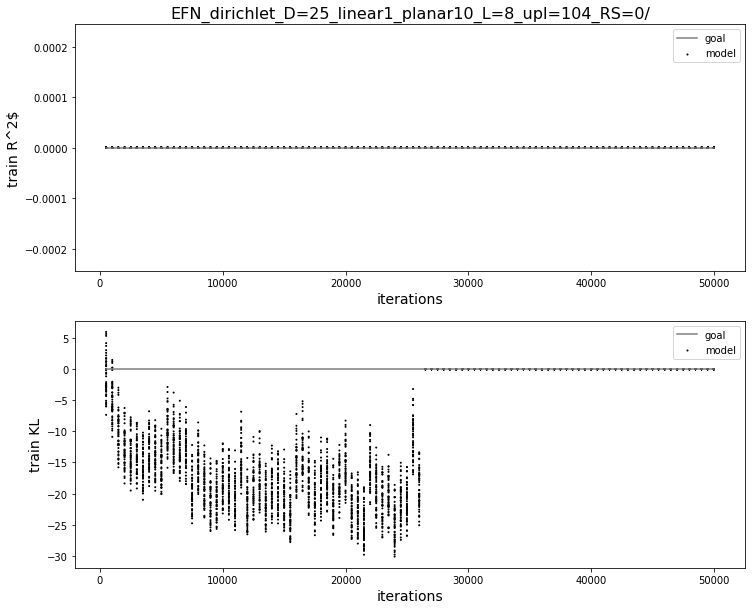

In [19]:
fontsize = 14;
N = train_R2s.shape[0];
K_eta = train_R2s.shape[1];
check_diagnostic_rate = 500;
its = check_diagnostic_rate*np.arange(1,N+1, dtype=float);
its = np.tile(np.expand_dims(its, 1), [1,K_eta]);
its_vec = np.reshape(its, (N*K_eta,));
train_R2s_vec = np.reshape(train_R2s, (N*K_eta,))
train_KLs_vec = np.reshape(train_KLs, (N*K_eta,))
size = np.ones((N*K_eta,));
fig = plt.figure(figsize=(12,10));
    
fig.add_subplot(2,1,1);
plt.plot([np.min(its), np.max(its)], [0,0], 'tab:gray');
plt.scatter(its_vec, train_R2s_vec,size,c='k');
plt.legend(['goal', 'model']);
plt.xlabel('iterations', fontsize=fontsize);
plt.xlabel('iterations', fontsize=fontsize);
plt.ylabel('train R^2$', fontsize=fontsize)
plt.title(modelstr, fontsize=fontsize+2)
    
fig.add_subplot(2,1,2);
plt.plot([np.min(its), np.max(its)], [0,0], 'tab:gray');
plt.scatter(its_vec, train_KLs_vec,size,c='k');
plt.legend(['goal', 'model']);
plt.xlabel('iterations', fontsize=fontsize);
plt.ylabel('train KL', fontsize=fontsize)

plt.show();


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


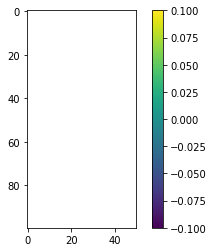

In [6]:
plt.figure();
plt.imshow(np.log(train_R2s));
plt.colorbar();
plt.show();